<a href="https://colab.research.google.com/github/viniciusaze/machine_learning/blob/main/Rede_neural_do_zero.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementando uma rede neural
Tratando problema do mnist

In [1]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [13]:
transform = transforms.ToTensor() # Definindo a conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data', train=True, download=True, transform=transform) # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data', train=False, download=True, transform=transform) # Carrega a parte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

Site: http://yann.lecun.com/exdb/mnist/

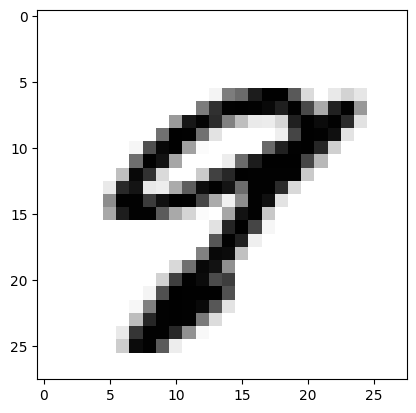

In [34]:
# Visualizando uma imagem da base de dados, para conferir se estamos lendo a base da forma correta
dataiter = iter(trainloader)
imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r');

In [18]:
# Conferindo o tamanho do tensor de uma imagem
print(imagens[0].shape) # Verificar as dimensões do tensor de cada imagem
print(etiquetas[0].shape) # Verificar as dimensões do tensor de cada etiqueta

torch.Size([1, 28, 28])
torch.Size([])


# Usando a rede InceptionV3 do Keras

In [19]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10) # camada interna 2, 64 neurônios que se ligam a 10
        # para a camada de saida não é necessário definir nada pois só precisamos pegar o output da camda interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X)) # função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X)) # função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X) # função de ativação da camada interna 2 para a camada de saída, nesse caso f(x) = x
        return F.log_softmax(X, dim=1) # dados utilizados para calcular a perda

In [22]:
def treino(modelo, trainloader, device):
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5) # define a politica de atualização dos pesos e da bias
    inicio = time() # timer para saber quanto tempo levou o treino

    criterio = nn.NLLLoss() # define o criterio para calcular a perda
    EPOCHS = 10 # número de epochs
    modelo.train() # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0 # inicializando a perda acumulada para a epoch

        for imagens, etiquetas in trainloader:
            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para "vetores"  de 28+28 casas para ficarem compatíveis com a
            otimizador.zero_grad() # zerando os gradientes

            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device)) # calculando a perda

            perda_instantanea.backward() # back propagation a partir da perda

            otimizador.step() # atualizando os pesos e bias

            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada

        else:
            print("Epoch {} - Perda Acumulada: {:.4f}".format(epoch+1, perda_acumulada/len(trainloader)))
    print("Tempo de treino (minutos):",(time()-inicio)/60)


In [23]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
          img = imagens[i].view(1, 784)
          # desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos tem custo alto de processamento
          with torch.no_grad():
              logps = modelo(img.to(device)) # output do modelo em escala logaritmica

          ps = torch.exp(logps) # converte output para escala normal(lembrando que é um tensor)
          probab = list(ps.cpu().numpy()[0]) # converte para lista
          etiqueta_pred = probab.index(max(probab)) # converte o tensor em um numero, no caso, o numero que o modelo previu como correto
          etiqueta_certa = etiquetas.numpy()[i]
          if (etiqueta_certa == etiqueta_pred): # compara a previsao com o valor correto
              conta_corretas += 1
          conta_todas += 1

    print('Total de imagens testadas = ', conta_todas)
    print('Taxa de acerto = ', (conta_corretas/conta_todas)*100)

In [24]:
modelo = Modelo()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)
treino(modelo, trainloader, device)

Epoch 1 - Perda Acumulada: 1.1676
Epoch 2 - Perda Acumulada: 0.3748
Epoch 3 - Perda Acumulada: 0.3070
Epoch 4 - Perda Acumulada: 0.2681
Epoch 5 - Perda Acumulada: 0.2379
Epoch 6 - Perda Acumulada: 0.2123
Epoch 7 - Perda Acumulada: 0.1917
Epoch 8 - Perda Acumulada: 0.1740
Epoch 9 - Perda Acumulada: 0.1590
Epoch 10 - Perda Acumulada: 0.1459
Tempo de treino (minutos): 1.8339111487070718
